In [58]:

import numpy as np
import pandas as pd
import keras
import keras.backend as K
from tensorflow.keras.optimizers import Adam
from keras.models import Sequential
from tensorflow.keras.utils import Sequence
from keras.layers import *
import matplotlib.pyplot as plt

# data = pd.read_csv("sudoku_dataset/sudoku.csv")
data = pd.read_csv("sudoku_dataset/sudoku.csv", nrows=1_000_000) 
data = pd.DataFrame({"problem":data["puzzle"],"solutions":data["solution"]})

In [59]:
import os
print(data.shape)
print(f"Problem:{os.linesep*2} {np.array(list(map(int,list(data['problem'][0])))).reshape(9,9)}")
print(f"Solution: {os.linesep*2} {np.array(list(map(int,list(data['solutions'][0])))).reshape(9,9)}")


(1000000, 2)
Problem:

 [[0 7 0 0 0 0 0 4 3]
 [0 4 0 0 0 9 6 1 0]
 [8 0 0 6 3 4 9 0 0]
 [0 9 4 0 5 2 0 0 0]
 [3 5 8 4 6 0 0 2 0]
 [0 0 0 8 0 0 5 3 0]
 [0 8 0 0 7 0 0 9 1]
 [9 0 2 1 0 0 0 0 5]
 [0 0 7 0 4 0 8 0 2]]
Solution: 

 [[6 7 9 5 1 8 2 4 3]
 [5 4 3 7 2 9 6 1 8]
 [8 2 1 6 3 4 9 5 7]
 [7 9 4 3 5 2 1 8 6]
 [3 5 8 4 6 1 7 2 9]
 [2 1 6 8 9 7 5 3 4]
 [4 8 5 2 7 6 3 9 1]
 [9 6 2 1 8 3 4 7 5]
 [1 3 7 9 4 5 8 6 2]]


In [60]:
class featureGeneration(Sequence):
    def __init__(self, dataset, batch_size = 16, action = "train", data_path = "sudoku_dataset/", info={}):
        super().__init__()
        self.dataset = dataset
        self.batch_size = batch_size
        self.action = action
        self.info = info   
        self.data_path = data_path
        self.on_epoch_end()
        
    def __len__(self):
        return int(np.floor(len(self.dataset)/self.batch_size))
    
    def on_epoch_end(self):
        self.indexes = np.arange(len(self.dataset))
   
    def __getitem__(self,index):
        X = np.empty((self.batch_size, 9,9,1))
        y = np.empty((self.batch_size,81,1))
        indexes = self.indexes[index*self.batch_size:(index+1)*self.batch_size]
        for i,f in enumerate(self.dataset['problem'].iloc[indexes]):
            self.info[index*self.batch_size+i]=f
            X[i,] = (np.array(list(map(int,list(f)))).reshape((9,9,1))/9)-0.5
        if self.action == 'train': 
            for i,f in enumerate(self.dataset['solutions'].iloc[indexes]):
                self.info[index*self.batch_size+i]=f
                y[i,] = np.array(list(map(int,list(f)))).reshape((81,1)) - 1
        if self.action == 'train': return X, y
        else: return X

In [61]:
model = Sequential()

model.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same', input_shape=(9,9,1)))
model.add(BatchNormalization())
model.add(Conv2D(64, kernel_size=(3,3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(128, kernel_size=(1,1), activation='relu', padding='same'))

model.add(Flatten())
model.add(Dense(81*9))
model.add(Reshape((-1, 9)))
model.add(Activation('softmax'))

adam = Adam(learning_rate=.001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=adam, metrics=['accuracy'])

In [62]:
train_idx = int(len(data)*0.95)
data = data.sample(frac=1).reset_index(drop=True)
training_data = featureGeneration(data.iloc[:train_idx], action = "train", batch_size=640)
validation_data = featureGeneration(data.iloc[train_idx:], action = "train",  batch_size=640)


from keras.callbacks import Callback, ModelCheckpoint, ReduceLROnPlateau
iter_model_file="weights-improv-{epoch:02d}-{val_accuracy:.2f}.hdf5"
model_file = "best_weights.hdf5"
checkpoint1 = ModelCheckpoint(iter_model_file, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
checkpoint2 = ModelCheckpoint(model_file, monitor='val_accuracy', verbose=1, save_best_only=True, mode='max')
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    patience=3,
    verbose=1,
    min_lr=1e-6
)
callbacks_list = [checkpoint1,checkpoint2,reduce_lr]


In [63]:
history = model.fit_generator(training_data, validation_data = validation_data, epochs = 10, verbose=1,callbacks=callbacks_list )

Epoch 1/10


C:\Users\rkhna\AppData\Local\Temp\ipykernel_28720\705601806.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  history = model.fit_generator(training_data, validation_data = validation_data, epochs = 10, verbose=1,callbacks=callbacks_list )


1484/1484 [==============================] - ETA: 0s - loss: 0.7456 - accuracy: 0.1114
Epoch 1: val_accuracy improved from -inf to 0.10835, saving model to weights-improv-01-0.11.hdf5

Epoch 1: val_accuracy improved from -inf to 0.10835, saving model to best_weights.hdf5
1484/1484 [==============================] - 669s 451ms/step - loss: 0.7456 - accuracy: 0.1114 - val_loss: 0.4400 - val_accuracy: 0.1084 - lr: 0.0010
Epoch 2/10
1484/1484 [==============================] - ETA: 0s - loss: 0.4211 - accuracy: 0.1109
Epoch 2: val_accuracy improved from 0.10835 to 0.11227, saving model to weights-improv-02-0.11.hdf5

Epoch 2: val_accuracy improved from 0.10835 to 0.11227, saving model to best_weights.hdf5
1484/1484 [==============================] - 734s 495ms/step - loss: 0.4211 - accuracy: 0.1109 - val_loss: 0.4140 - val_accuracy: 0.1123 - lr: 0.0010
Epoch 3/10
1484/1484 [==============================] - ETA: 0s - loss: 0.4030 - accuracy: 0.1111
Epoch 3: val_accuracy improved from 0.112

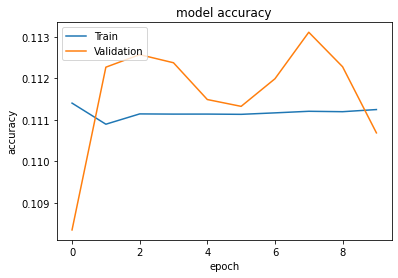

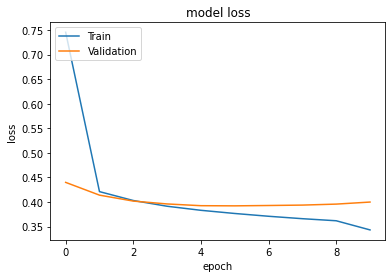

In [64]:
# summarize history for loss
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

In [65]:
model.load_weights(model_file)

In [66]:
def normalize(a):
    return (a/9)-.5

def denormalize(a):
    return (a+.5)*9

def fill_sudoku_with_trained_model(problem):    
    feat = problem
    
    while True:
        out = model.predict(feat.reshape((1,9,9,1)))  
        out = out.squeeze()

        pred = np.argmax(out, axis=1).reshape((9,9))+1 
        prob = np.around(np.max(out, axis=1).reshape((9,9)), 2) 
        
        feat = denormalize(feat).reshape((9,9))
        mask = (feat==0)

        if(mask.sum()==0):
            break
            
        prob_new = prob*mask
        ind = np.argmax(prob_new)
        x, y = (ind//9), (ind%9)
        val = pred[x][y]
        feat[x][y] = val
        feat = normalize(feat)
    return pred

def test_accuracy(feats, labels):
    correct = 0
    for i,feat in enumerate(feats):
        pred = fill_sudoku_with_trained_model(feat)
        true = labels[i].reshape((9,9))+1
        if(abs(true - pred).sum()==0):
            correct += 1
    print(correct/feats.shape[0])

def solve_sudoku(game):
    game = game.replace('\n', '')
    game = game.replace(' ', '')
    game = np.array([int(j) for j in game]).reshape((9,9,1))
    game = normalize(game)
    game = fill_sudoku_with_trained_model(game)
    return game

In [77]:
game = '''
            2 1 0 0 6 0 0 0 0 
            0 3 0 0 0 0 0 0 0 
            6 0 0 0 0 0 4 9 7 
            0 0 0 0 0 0 3 0 4 
            0 0 0 0 0 9 0 6 0 
            0 7 3 0 5 0 8 0 0 
            5 0 0 4 0 7 9 0 1 
            0 0 2 0 1 0 0 0 0 
            0 0 0 0 0 0 0 0 0 
      '''
game = solve_sudoku(game1)

print('\tsolved sudoku puzzle\n')
print(game)

	solved sudoku puzzle

[[8 6 7 1 3 4 9 5 2]
 [2 4 1 5 9 6 7 8 3]
 [3 9 5 8 7 2 6 1 4]
 [9 7 8 6 2 5 4 3 1]
 [4 5 6 3 1 8 2 7 9]
 [1 2 3 9 4 7 8 6 5]
 [5 3 4 7 6 9 1 2 8]
 [6 1 9 2 8 3 5 4 7]
 [7 8 2 4 5 1 3 9 6]]


In [83]:
problem_set = data.head(5)['problem'].to_list()
for problem in problem_set:
    game = solve_sudoku(problem)
    print(problem)
    print(f"\tsolved sudoku puzzle\n {game}")

400079002759213000260000790000008501590360007010754086106002070007036010000000264
	solved sudoku puzzle
 [[4 8 3 6 7 9 1 5 2]
 [7 5 9 2 1 3 6 4 8]
 [2 6 1 8 4 5 7 9 3]
 [6 7 4 9 2 8 5 3 1]
 [5 9 8 3 6 1 4 2 7]
 [3 1 2 7 5 4 9 8 6]
 [1 4 6 5 8 2 3 7 9]
 [9 2 7 4 3 6 8 1 5]
 [8 3 5 1 9 7 2 6 4]]
300100205508300014007240863002000000000502080046830052009600341400023000003480020
	solved sudoku puzzle
 [[3 6 4 1 7 8 2 9 5]
 [5 2 8 3 9 6 7 1 4]
 [1 9 7 2 4 5 8 6 3]
 [8 5 2 7 1 4 9 3 6]
 [9 3 1 5 6 2 4 8 7]
 [7 4 6 8 3 9 1 5 2]
 [2 8 9 6 5 7 3 4 1]
 [4 1 5 9 2 3 6 7 8]
 [6 7 3 4 8 1 5 2 9]]
008603010090004872000000004830961000207430006904000380073280000621097058080046020
	solved sudoku puzzle
 [[7 4 8 6 2 3 9 1 5]
 [3 9 6 5 1 4 8 7 2]
 [1 5 2 8 7 9 6 3 4]
 [8 3 5 9 6 1 2 4 7]
 [2 1 7 4 3 8 5 9 6]
 [9 6 4 7 5 2 3 8 1]
 [4 7 3 2 8 5 1 6 9]
 [6 2 1 3 9 7 4 5 8]
 [5 8 9 1 4 6 7 2 3]]
008900300400720069796003100810030705307089012562004000605008000200005090900200500
	solved sudoku puzzle
 [[1 2 8 9 

In [116]:
import ast
arrayToListSolution=np.array2string(game, separator="").replace("\n",",")
solution_string = ''.join([str(i[0]) for i in ast.literal_eval(arrayToListSolution)])
print(solution_string)

165847923289513647734962581941356872827491365356728419592674138478135296613289754
